In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math
import timeit
from downfun import *

# Individual Stocks

In [3]:
bb = yf.Ticker("BB")

In [14]:
bb.info.keys()

dict_keys(['zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'state', 'country', 'companyOfficers', 'website', 'maxAge', 'address1', 'industry', 'previousClose', 'regularMarketOpen', 'twoHundredDayAverage', 'trailingAnnualDividendYield', 'payoutRatio', 'volume24Hr', 'regularMarketDayHigh', 'navPrice', 'averageDailyVolume10Day', 'totalAssets', 'regularMarketPreviousClose', 'fiftyDayAverage', 'trailingAnnualDividendRate', 'open', 'toCurrency', 'averageVolume10days', 'expireDate', 'yield', 'algorithm', 'dividendRate', 'exDividendDate', 'beta', 'circulatingSupply', 'startDate', 'regularMarketDayLow', 'priceHint', 'currency', 'regularMarketVolume', 'lastMarket', 'maxSupply', 'openInterest', 'marketCap', 'volumeAllCurrencies', 'strikePrice', 'averageVolume', 'priceToSalesTrailing12Months', 'dayLow', 'ask', 'ytdReturn', 'askSize', 'volume', 'fiftyTwoWeekHigh', 'forwardPE', 'fromCurrency', 'fiveYearAvgDividendYield', 'fiftyTwoWeekLow', 'bid', 'tradeable', 'dividendY

# Multiple Tickers / Portfolios / Indices

In [5]:
portfolio_tickers = ["BB", "BP", "AMD", "AAL", "PLTR", "KO", "V", "CRM"]
portfolio_weights = np.repeat(1/len(portfolio_tickers), len(portfolio_tickers))
portfolio = yf.Tickers(" ".join(portfolio_tickers))

In [101]:
[portfolio.tickers[i].info.get('sector') for i in portfolio_tickers]
[portfolio.tickers[i].info.get('marketCap') for i in portfolio_tickers]
[portfolio.tickers[i].info.get('industry') for i in portfolio_tickers]
[portfolio.tickers[i].info.get('previousClose') for i in portfolio_tickers]

[9.06, 25.5, 83.91, 21.3, 23.37, 54.26, 236.86, 234.36]

# Financial Statements

In [186]:
port_financial = {i : portfolio.tickers[i].get_financials() for i in portfolio_tickers}
port_balance_sheet = {i : portfolio.tickers[i].get_balance_sheet() for i in portfolio_tickers}
port_cashflow = {i : portfolio.tickers[i].get_cashflow() for i in portfolio_tickers}

# Mean - Variance

In [254]:
port_stock_history = {ticker : portfolio.tickers[ticker].history(period = "5y") for ticker in portfolio_tickers} 

In [341]:
for ticker in port_stock_history:
    port_stock_history[ticker]['log_returns'] = np.log(port_stock_history[ticker].Close/port_stock_history[ticker].Close.shift(1))

In [355]:
#Daily
mean_log_rets = {ticker : port_stock_history[ticker].log_returns.mean() for ticker in portfolio_tickers}
stdev_log_rets = {ticker : port_stock_history[ticker].log_returns.std() for ticker in portfolio_tickers}
mean_log_rets

{'BB': 0.00017782985896287024,
 'BP': 3.0069867934254848e-05,
 'AMD': 0.0024507064782608363,
 'AAL': -0.0003346090425785444,
 'PLTR': 0.006068082718887838,
 'KO': 0.0002756742975310548,
 'V': 0.0008936678895269704,
 'CRM': 0.0008683805741862102}

In [396]:
#Monthly
monthly_log_returns = {ticker: port_stock_history[ticker].resample('M')['log_returns'].sum() for ticker in portfolio_tickers}
pd.concat(monthly_log_returns, axis = 1).apply(np.mean)
pd.concat(monthly_log_returns, axis = 1).apply(np.std)

BB      0.155811
BP      0.073683
AMD     0.155917
AAL     0.132251
PLTR    0.388298
KO      0.047649
V       0.057267
CRM     0.077907
dtype: float64

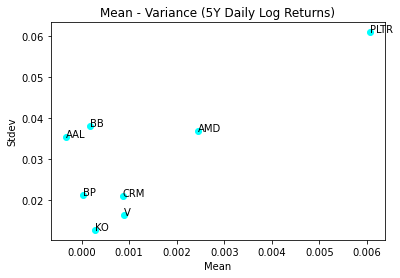

In [426]:
plt.scatter(x = mean_log_rets.values(), y = stdev_log_rets.values(), color = 'cyan')
plt.title("Mean - Variance (5Y Daily Log Returns)")
plt.xlabel("Mean")
plt.ylabel("Stdev")
for ticker in portfolio_tickers:
    plt.annotate(ticker, (mean_log_rets[ticker], stdev_log_rets[ticker]))

# Trying finratios and balratios functions
- Experimentary
    - findict returns pandas df
    - baldict returns dict

In [44]:
def tfunc(x):
    return x.T.reset_index(drop = True).T

findict = {ticker : finratios(ticker) for ticker in portfolio_tickers}
baldict = {ticker : balratios(ticker) for ticker in portfolio_tickers}

In [49]:
pd.concat({key : tfunc(df) for key, df in findict.items()})

0             1             2         3
BB  ns_growth    -1.470000e+08  1.360000e+08 -2.800000e+07       NaN
    ni_growth    -9.520000e+08 -2.450000e+08 -3.120000e+08       NaN
    gmargin       2.799552e-01  2.615385e-01  2.256637e-01  0.269313
    omargin      -1.075028e-01 -1.961538e-01 -4.756637e-02 -0.113734
    nmargin      -1.236282e+00 -1.461538e-01  1.028761e-01  0.434549
...                        ...           ...           ...       ...
CRM nmargin       1.916055e-01  7.369283e-03  8.357175e-02  0.034156
    ir           -3.094303e-02 -1.039683e+00 -1.180180e-01 -0.363889
    eftax        -5.900039e-01  8.215297e-01 -1.291963e-01  0.142857
    sga_to_sales  5.534067e-01  5.611183e-01  5.578979e-01  0.546490
    rd_intensity  1.693017e-01  1.617733e-01  1.419967e-01  0.147343

[72 rows x 4 columns]

In [45]:
pd.concat({key : tfunc(pd.DataFrame(v).T) for key, v in baldict.items()})

0             1             2  \
BB  Total Assets                  2.818000e+09  3.888000e+09  3.968000e+09   
    Total Liabilities             1.314000e+09  1.359000e+09  1.332000e+09   
    Total Equity                  1.504000e+09  2.529000e+09  2.636000e+09   
    Current Operating Assets      1.006000e+09  1.196000e+09  1.233000e+09   
    Current Operating Liabilties  4.290000e+08  1.121000e+09  5.100000e+08   
...                                        ...           ...           ...   
CRM LT Operating Liabilities      7.080000e+09  6.396000e+09  3.877000e+09   
    Financing Liabilities         0.000000e+00  0.000000e+00  0.000000e+00   
    Financing Assets              0.000000e+00  0.000000e+00  0.000000e+00   
    Invested Capital              4.149300e+10  3.388500e+10  1.560500e+10   
    Net Debt                      0.000000e+00  0.000000e+00  0.000000e+00   

                                             3  
BB  Total Assets                  3.780000e+09  
    Total Liabilities             1.275000e+09  
    Total Equity                  2.505000e+09  
    Current Operating Assets      2.545000e+09  
    Current Operating Liabilties  4.110000e+08  
...                                        ...  
CRM LT Operating Liabilities      1.541000e+09  
    Financing Liabilities         0.000000e+00  
    Financing Assets              0.000000e+00  
    Invested Capital              1.037600e+10  
    Net Debt                      0.000000e+00  

[104 rows x 4 columns]

In [46]:
%%timeit -n3 -r1
findict = {ticker : finratios(ticker) for ticker in portfolio_tickers}
pd.concat({key : tfunc(df) for key, df in findict.items()})

13.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [48]:
%%timeit -n3 -r1
baldict = {ticker : balratios(ticker) for ticker in portfolio_tickers}
pd.concat({key : tfunc(pd.DataFrame(v).T) for key, v in baldict.items()})

13.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
